In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import Input
from keras.models import Model
from keras import backend as K
from keras import regularizers
import tensorflow as  tf

import scipy.io as scio


%matplotlib inline

Using TensorFlow backend.


In [2]:
def gauss_standard(x):
    return np.exp(-0.5*np.square(x))/(np.sqrt(2*np.pi))

def scale(X,center=True,scale=True):
    if(center==True):
        X =X -np.mean(X,axis=0)
    if(scale==True):
        X =X/np.std(X,axis=0)
    return X
    
def whiten(X):
    [N,p] =X.shape
    cov =(X.T@X)/N
    [eig_vals,eig_vecs] =np.linalg.eig(cov)
    P =(np.diag(1.0/np.sqrt(eig_vals)))@eig_vecs.T
    return [P,(P@X.T).T]

def group(y,B=500):
    N =y.shape[0]
    y =np.sort(y)
    y_min =y[0]
    y_max =y[-1]
    freqs =np.zeros((B,),dtype=float)
    ys    =np.zeros((B,),dtype=float)
    gaps =(y_max-y_min)/(B-1)
    left =y_min -0.5*gaps
    ys =y_min+gaps*np.arange(B)
    index =0
    for i in range(N):
        index =int(np.floor((y[i]-left)/gaps))
        freqs[index] = freqs[index]+1.0
    freqs =freqs/gaps
    return [ys,freqs]
        
        
    
    

def Amari_metric(A0,A):
    R =np.abs(A0@np.linalg.inv(A))
    m =A0.shape[0]
    row_max =np.max(R,axis=1)
    col_max =np.max(R,axis=0)
    return -1.0+(np.sum(np.sum(R,axis=1)/row_max)+np.sum(np.sum(R,axis=0)/col_max))/(2*m)
    
def mixmat(m):
    A =np.random.normal(size=(m,m))
    [u,s,vh] =np.linalg.svd(A,full_matrices=True)
    d =np.sort(np.random.uniform(low=0.0,high=1.0,size=(m,)))+1.0
    print('condition ',d[-1]/d[0])
    A =u@vh.T@np.diag(d)
    return A

def orth(W):
    [u,s,vh] =np.linalg.svd(W,full_matrices=True)
    W =u@vh
    return W


def mdi_loss(y_true,y_pred):
    #怎么不是在最小化，而是在增大
    norm_val =K.exp(y_pred)*y_true
    #return (K.log(K.mean(norm_val,axis=-1))-(K.mean(norm_val*y_pred,axis=-1)/K.mean(norm_val,axis=-1)))
    return ((K.log(K.mean(norm_val,axis=-1))-(K.mean(y_pred,axis=-1)/(K.mean(norm_val,axis=-1)+K.epsilon()))))
def mdi_loss2(y_true,y_pred):
    norm_val =K.exp(y_pred)*y_true
    return K.mean(norm_val,axis=-1)-K.mean(y_pred,axis=-1)


def mdi_loss3(y_true,y_pred):
    norm_val =K.exp(y_pred)*y_true
    return K.mean(norm_val,axis=-1)*K.log(K.mean(norm_val,axis=-1))-K.mean(y_pred,axis=-1)

def mdi_loss4(y_true,y_pred):
    #很快收敛但是十分不稳定。
    return K.mean(K.exp(y_pred),axis=-1)-K.mean(y_true*y_pred,axis=-1)

def mdi_loss5(y_true,y_pred):
    #很快收敛但是十分不稳定。
    return K.sum(y_pred,axis=-1)-K.sum(y_true*K.log(y_pred),axis=-1)

def negentropy(y_true,y_pred):
    return K.mean(y_pred,axis=-1)



In [3]:
path =r"./data/dists.mat"
data = scio.loadmat(path)["dists"]

S shape  (1024, 2)
condition  1.17251784136


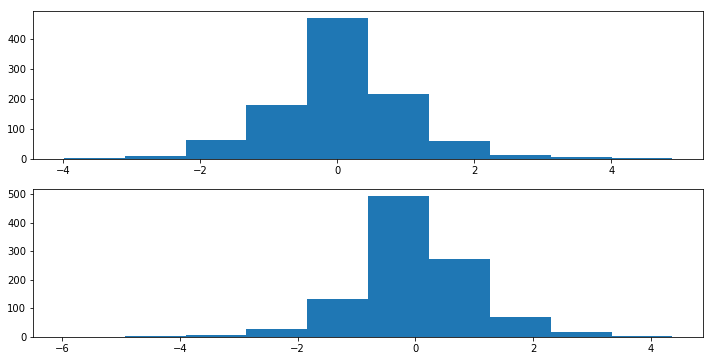

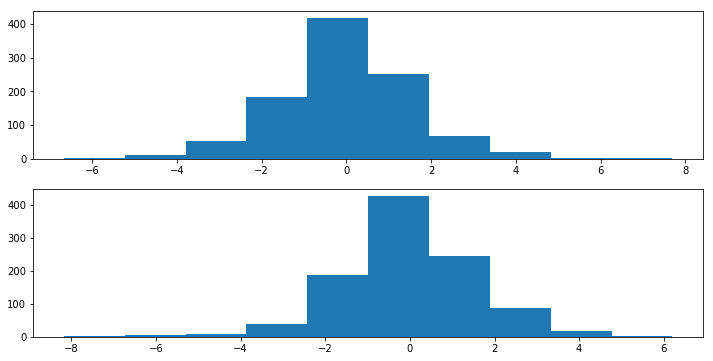

In [13]:
m  =2
S  =data[[1,1],[3,4],:].T
#s1 =np.random.binomial(100,0.33,1024)[:,np.newaxis]
#s2 =np.random.binomial(250,0.55,1024)[:,np.newaxis]
#S =np.c_[s1,s2]
print('S shape ',S.shape)
A0 =mixmat(2)
#A0 =np.array([[0.4,0.6],[0.2,0.7]],dtype=float)
X  =(A0@S.T).T

plt.subplots(figsize=(12,6))
for i in range(m):
    plt.subplot(m,1,i+1)
    plt.hist(S[:,i])


plt.subplots(figsize=(12,6))
for i in range(m):
    plt.subplot(m,1,i+1)
    plt.hist(X[:,i])

X  =scale(X,center=True,scale=False)
[P,X] =whiten(X)
target =np.linalg.inv(P@A0)
W0 =np.random.normal(size=(2,2))
W0 =orth(W0)

In [ ]:
tf_session = K.get_session()
tf_session.run(tf.global_variables_initializer())
y =K.variable([-0.5,2.0], dtype='float32', name="y") 
w =K.variable(np.ones((1024)), dtype='float32', name="w")
print("y ",K.eval(y))
print("w ",K.eval(w))
res=-1.0*K.square(y)
print(K.eval(K.gradients(res,[y])[0]))

In [7]:
def neuralICA(X,W0,M=1024,maxiters=20,epochs=400,optimizer='rmsprop',tol=1e-7,activation='sigmoid',lbd=0.05):
    [N,p] =X.shape
    batch_size =N
    m =p
    models =[]
    inputs =[]
    outputs =[]
    loss     =np.zeros((maxiters,m),dtype=float)
    metrices =np.zeros((maxiters,m),dtype=float)
    y_pred =np.zeros((N,m),dtype=float)
    tol =1e-7
    W=W0
    W_last =np.ones(W0.shape,dtype=float)
    for i in range(m):
        input_tensor =Input(shape=(1,),dtype='float32')
        x =layers.Dense(M,activation=activation,kernel_initializer='random_uniform',
                bias_initializer='zeros')(input_tensor)
        #x =layers.Dense(50,activation='sigmoid',kernel_initializer='random_uniform',
        #            bias_initializer='zeros',kernel_regularizer=regularizers.l1(1))(x)
        output_tensor =layers.Dense(1,activation="linear",kernel_initializer='random_uniform',
                bias_initializer='zeros',kernel_regularizer=regularizers.l2(lbd))(x)
        model =Model(input_tensor,output_tensor)
        model.compile(optimizer=optimizer,loss=mdi_loss2,metrics=[negentropy])
        models.append(model)
        inputs.append(input_tensor)
        outputs.append(output_tensor)

    for i in range(maxiters):
        print('iteration ',i,' begin')
        X_train =(W@X.T).T
        y_train =gauss_standard(X_train)
        #print('dist ',Amari_metric(W_last,W))
        if(Amari_metric(W_last,W)<tol):
            break
        W_last =W.copy()
        for j in range(m):
            for k in range(epochs):
                #print('epochs ',k)
                [loss[i,j],metrices[i,j]] =models[j].train_on_batch(x=X_train[:,j],y=y_train[:,j])
                #models[j].fit(X_train[:,j][:,np.newaxis],y_train[:,j][:,np.newaxis],epochs=100,batch_size=1024,verbose=0)
                grad  =K.gradients(models[j].output,[models[j].input])[0]
                grad2 =K.gradients(grad,[models[j].input])[0]
                grads =K.function([models[j].input],[grad,grad2])
                #print('grad ',grad)
                #print('grad2 ',grad2)
                #K.update(models[j].input,X_train[:,j])
                [grad_val,grad2_val] =grads([X_train[:,j][:,np.newaxis]])
        
                #print('norm ',np.linalg.norm(grad_val))
                #print('grad_val ',grad_val)
                W[j,:] =np.mean(X*grad_val,axis=0)-np.mean(grad2_val)*W[j,:]
                #if(j>0):
                #      W[j,:] =W[j,:]-(np.sum(W[j,:]*W[j-1,:]))*W[j-1,:]
                #W[j,:] =W[j,:]/np.linalg.norm(W[j,:])
               #print('before W ',W)
        W =orth(W)
        #if(i<10):
        #    print('W_last ',W_last)
        #    print('W ',W )
        #print('epoch ',i,' Amari metric: ',Amari_metric(target,W))
        
        print('iteration ',i,' loss ',loss[i,:],' negentropy ',metrices[i,:])
    return [W,metrices]
        
    
    



In [14]:
model.compile(optimizer='rmsprop',loss=mdi_loss,metrics=[negentropy])

In [ ]:
#M=200 lbd=0.05还行
#神经网络需要调整参数，不是很好的问题，不值得太花费时间.
maxiters =50
epochs =200
batch_size =1024
m  =2
M  =200
W =np.random.normal(size=(m,m))
W =orth(W)
W_last =np.random.normal(size=(m,m))
print('Amari metric ',Amari_metric(target,W))
models =[]
inputs =[]
outputs =[]
loss     =np.zeros((maxiters,m),dtype=float)
metrices =np.zeros((maxiters,m),dtype=float)
y_pred =np.zeros((1024,m),dtype=float)
tol =1e-7
for i in range(m):
    input_tensor =Input(shape=(1,),dtype='float32')
    x =layers.Dense(M,activation='sigmoid',kernel_initializer='random_uniform',
                bias_initializer='zeros')(input_tensor)
    #x =layers.Dense(50,activation='sigmoid',kernel_initializer='random_uniform',
    #            bias_initializer='zeros',kernel_regularizer=regularizers.l1(1))(x)
    output_tensor =layers.Dense(1,activation="linear",kernel_initializer='random_uniform',
                bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.09))(x)
    model =Model(input_tensor,output_tensor)
    model.compile(optimizer='rmsprop',loss=mdi_loss4,metrics=[negentropy])
    models.append(model)
    inputs.append(input_tensor)
    outputs.append(output_tensor)

for i in range(maxiters):
    #X_train =(W@X.T).T
    #y_train =gauss_standard(X_train)
    Xs =(W@X.T).T
    #[X_train,y_train] =group(X_train)
    print('dist ',Amari_metric(W_last,W))
    if(Amari_metric(W_last,W)<tol):
        break
    W_last =W.copy()
    for j in range(m):
        [X_train,y_train] =group(Xs[:,j],B=500)
        y_train =y_train/gauss_standard(X_train)
        for k in range(epochs):
            [loss[i,j],metrices[i,j]] =models[j].train_on_batch(x=X_train,y=y_train)
        #models[j].fit(X_train[:,j][:,np.newaxis],y_train[:,j][:,np.newaxis],epochs=100,batch_size=1024,verbose=0)
        grad  =K.gradients(models[j].output,[models[j].input])[0]
        grad2 =K.gradients(grad,[models[j].input])[0]
        grads =K.function([models[j].input],[grad,grad2])
        #print('grad ',grad)
        #print('grad2 ',grad2)
        #K.update(models[j].input,X_train[:,j])
        [grad_val,grad2_val] =grads([Xs[:,j][:,np.newaxis]])
        
        #print('norm ',np.linalg.norm(grad_val))
        #print('grad_val ',grad_val)
        W[j,:] =np.mean(X*grad_val,axis=0)-np.mean(grad2_val)*W[j,:]
        if(j>0):
            W[j,:] =W[j,:]-(np.sum(W[j,:]*W[j-1,:]))*W[j-1,:]
        W[j,:] =W[j,:]/np.linalg.norm(W[j,:])
    #print('before W ',W)
    #W =orth(W)
    #if(i<10):
    #    print('W_last ',W_last)
    #    print('W ',W )
    print('epoch ',i,' Amari metric: ',Amari_metric(target,W))
    print('loss ',loss[i,:])
    print('metrices ',metrices[i,:])
        
    

Amari metric  0.142456072966
dist  0.418396952833
epoch  0  Amari metric:  0.93481166614
loss  [ -1.57852710e+09  -1.06142675e+06]
metrices  [ 15.14108276   9.67463684]
dist  0.698813598568
epoch  1  Amari metric:  0.817036672799
loss  [ -7.86921440e+07  -2.67438926e+04]
metrices  [ 15.03038883   8.1757021 ]
dist  0.135548343911
epoch  2  Amari metric:  0.726329029843
loss  [-7751785.5          -15444.62597656]
metrices  [ 11.16394806   7.71894932]
dist  0.0568421760264
epoch  3  Amari metric:  0.682020591891
loss  [-2759926.75         -16731.91015625]
metrices  [ 10.47092819   7.85259581]
dist  0.029591977076
epoch  4  Amari metric:  0.672158624942
loss  [-1661622.5          -19094.34960938]
metrices  [ 9.95923233  7.95991659]
dist  0.00675375485571
epoch  5  Amari metric:  0.633547442259
loss  [-1503711.25         -20478.90039062]
metrices  [ 8.92173004  7.96365738]
dist  0.0270478696
epoch  6  Amari metric:  0.6484127249
loss  [-959023.1875    -25463.453125]
metrices  [ 9.35277843  

In [ ]:
group(Xs[:,0])

In [8]:
[W,metrics]=neuralICA(X,W0=W0,M=200,maxiters=20,epochs=200,optimizer='rmsprop',tol=1e-7,activation='sigmoid',lbd=0.05)

iteration  0  begin


KeyboardInterrupt: 

(18, 100, 1024)

In [ ]:
dim2data =np.zeros((18,30,2,1024),dtype=float)
dim2target =np.zeros((18,30,2,2),dtype=float)
dim2W0 =np.zeros((18,30,2,2),dtype=float)
dim2W  =np.zeros((18,30,2,2),dtype=float)
amaris =np.zeros((18,30),dtype=float)
maxiters =20
epochs =20
M=1024
for ii in range(18):
    for jj in range(30):
        m  =2
        S  =data[ii,[jj,jj+30],:].T
        A0 =mixmat(2)
        X  =(A0@S.T).T
        X  =scale(X,center=True,scale=False)
        [P,X] =whiten(X)
        target =np.linalg.inv(P@A0)
        W0 =np.random.normal(size=(2,2))
        W0 =orth(W0)
        
        W =W0.copy()
        W_last =np.random.normal(size=(m,m))

        models =[]
        inputs =[]
        outputs =[]
        loss     =np.zeros((maxiters,m),dtype=float)
        metrices =np.zeros((maxiters,m),dtype=float)
        y_pred =np.zeros((1024,m),dtype=float)
        tol =1e-7
        for i in range(m):
            input_tensor =Input(shape=(1,),dtype='float32')
            x =layers.Dense(M,activation='sigmoid',kernel_initializer='random_uniform',
                bias_initializer='zeros')(input_tensor)
            output_tensor =layers.Dense(1,activation="linear",kernel_initializer='random_uniform',
                bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.05))(x)
            model =Model(input_tensor,output_tensor)
            model.compile(optimizer='rmsprop',loss=mdi_loss2,metrics=[negentropy])
            models.append(model)
            inputs.append(input_tensor)
            outputs.append(output_tensor)
        for i in range(maxiters):
            
            X_train =(W@X.T).T
            []
            if(Amari_metric(W_last,W)<tol):
                break
            W_last =W.copy()
            for j in range(m):
                for k in range(epochs):
                    [loss[i,j],metrices[i,j]] =models[j].train_on_batch(x=X_train[:,j],y=y_train[:,j])
                grad  =K.gradients(models[j].output,[models[j].input])[0]
                grad2 =K.gradients(grad,[models[j].input])[0]
                grads =K.function([models[j].input],[grad,grad2])
                [grad_val,grad2_val] =grads([X_train[:,j][:,np.newaxis]])
                W[j,:] =np.mean(X*grad_val,axis=0)-np.mean(grad2_val)*W[j,:]

            W =orth(W)
            #print('epoch ',i,' Amari metric: ',Amari_metric(target,W))
            #print('loss ',loss[i,:])
            #print('metrices ',metrices[i,:])
        
    dim2data[ii,jj,:,:]=S.T.copy()
    dim2target[ii,jj,:,:] =target.copy()
    dim2W0[ii,jj,:,:]=W0.copy()
    dim2W[ii,jj,:,:] =W.copy()
    amaris[ii,jj] =Amari_metric(target,W)
        
        
        

condition  1.37894287867
condition  1.253542588
condition  1.55775619345
condition  1.45484727925
condition  1.00702291659
condition  1.0038730418
condition  1.21191847819
condition  1.0454329456
condition  1.07785104355
condition  1.24011916343
condition  1.28180860331
condition  1.03850530372
condition  1.06004238406
condition  1.09420849669
condition  1.22337499737
condition  1.25175975608
condition  1.14557891996
condition  1.64536132015
condition  1.06905215078
condition  1.07057263912
condition  1.5233731116
condition  1.29257158662
condition  1.26812319581
condition  1.11100397832
condition  1.44701599948
condition  1.42649475442
condition  1.20707971668
condition  1.34022959757
condition  1.42477909621
condition  1.36521509776
condition  1.03017156495
condition  1.53077594929
condition  1.05494480051
condition  1.08987274595
condition  1.15420903715
condition  1.40239418926
condition  1.03946812433
condition  1.52994770336
condition  1.2295761528
condition  1.10868435732
condit

In [44]:
epochs =20
batch_size =1024
m  =2
M  =50
W =np.random.normal(size=(m,m))
W =orth(W)
W_last =np.random.normal(size=(m,m))
print('Amari metric ',Amari_metric(target,W))
models =[]
inputs =[]
outputs =[]
loss     =np.zeros((epochs,m),dtype=float)
metrices =np.zeros((epochs,m),dtype=float)
y_pred =np.zeros((1024,m),dtype=float)
tol =1e-7
for i in range(m):
    input_tensor =Input(shape=(1,),dtype='float32')
    x =layers.Dense(M,activation='sigmoid',kernel_initializer='random_uniform',
                bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.001))(input_tensor)
    x =layers.Dense(50,activation='sigmoid',kernel_initializer='random_uniform',
                bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.001))(x)
    output_tensor =layers.Dense(1,activation="softplus",kernel_initializer='random_uniform',
                bias_initializer='zeros',kernel_regularizer=regularizers.l2(0.05))(x)
    model =Model(input_tensor,output_tensor)
    model.compile(optimizer='rmsprop',loss=mdi_loss5,metrics=[negentropy])
    models.append(model)
    inputs.append(input_tensor)
    outputs.append(output_tensor)

for i in range(epochs):
    #X_train =(W@X.T).T
    #y_train =gauss_standard(X_train)
    Xs =(W@X.T).T
    #[X_train,y_train] =group(X_train)
    print('dist ',Amari_metric(W_last,W))
    if(Amari_metric(W_last,W)<tol):
        break
    W_last =W.copy()
    for j in range(m):
        [X_train,y_train] =group(Xs[:,j],B=500)
        
        for k in range(400):
            [loss[i,j],metrices[i,j]] =models[j].train_on_batch(x=X_train,y=y_train)
        #models[j].fit(X_train[:,j][:,np.newaxis],y_train[:,j][:,np.newaxis],epochs=100,batch_size=1024,verbose=0)
        grad  =K.gradients(models[j].output,[models[j].input])[0]
        grad2 =K.gradients(grad,[models[j].input])[0]
        grads =K.function([models[j].input],[grad,grad2,models[j].output])
        #print('grad ',grad)
        #print('grad2 ',grad2)
        #K.update(models[j].input,X_train[:,j])
        [grad_val,grad2_val,y_pred] =grads([Xs[:,j][:,np.newaxis]])
        g1 =grad_val/y_pred
        g2 =(grad2_val*y_pred-grad_val*grad_val)/(y_pred*y_pred)
        
        #print('norm ',np.linalg.norm(grad_val))
        #print('grad_val ',grad_val)
        #W[j,:] =W[j,:] -(np.mean(X*g1,axis=0))/np.mean(g2)
        W[j,:] =np.mean(X*g1,axis=0)-np.mean(g2)*W[j,:]
        #if(j>0):
        #    W[j,:] =W[j,:]-(np.sum(W[j,:]*W[j-1,:]))*W[j-1,:]
        #W[j,:] =W[j,:]/np.linalg.norm(W[j,:])
    #print('before W ',W)
    W =orth(W)
    #if(i<10):
    #    print('W_last ',W_last)
    #    print('W ',W )
    print('epoch ',i,' Amari metric: ',Amari_metric(target,W))
    print('loss ',loss[i,:])
    print('metrices ',metrices[i,:])
        
    

Amari metric  0.312182193261
dist  0.725816088103


LookupError: No gradient defined for operation 'gradients_818/dense_112/Softplus_grad/SoftplusGrad' (op type: SoftplusGrad)